## Setting file paths

#### BERT-RDM Model 

In [1]:
root = './'
plots_root = root + 'Plots/'
datasets_root = root + 'Datasets/'
behavioural_data_root = root +  'behavioral_data/selected_data/' 
stan_files_root = root +  'stan files/' 
saved_models_root = root + 'stan_results/'

plots_folder_name = 'BERT-RDM/'
dataset_name = 'BERT.csv'
stan_file_name = 'RDM_hier_2k_beta_f.stan'
saved_model_name = 'BERT'

plots_path = plots_root + plots_folder_name
dataset_path = datasets_root + dataset_name
stan_file_path = stan_files_root + stan_file_name
saved_model_path = saved_models_root + saved_model_name  + '.pkl'

## Importing Packages

In [2]:
import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from scipy.stats import gaussian_kde

In [3]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

## Prepare data

Loading words and non-words with zipf and predicted probabilities

In [4]:
word_nword_df = pd.read_csv(dataset_path, header=None, names =['string', 'freq',  'label', 'zipf','category', 'word_prob', 'non_word_prob'])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,sevenue,0,0,0.000000,NW,0.192300,0.807700
1,tisguided,0,0,0.000000,NW,0.454265,0.545735
2,importunt,0,0,0.000000,NW,0.970227,0.029773
3,rainsall,0,0,0.000000,NW,0.016630,0.983370
4,gonveniently,0,0,0.000000,NW,0.592695,0.407305
...,...,...,...,...,...,...,...
74312,vetail,0,0,0.000000,NW,0.022865,0.977135
74313,espionage,1292,1,3.236317,HF,0.988338,0.011662
74314,Wilholm,0,0,0.000000,NW,0.238690,0.761310
74315,compuler,0,0,0.000000,NW,0.171943,0.828057


In [5]:
def remove_outliers(df, max_rt, min_rt, std_c=2.5):
    """
    Returns remove outliers from dataframes. Outlier RTs are bigger than
    max_rt and smaller than min_rt. Also RTsthat are out of -/+ (std_c * sd) 
    of mean RT interval are considered as outliers too.

    Parameters
    ----------
        df: pandas dataframe with rt column
        max_rt (float): maximum acceptable rt
        min_rt (float): minimum acceptable rt
        
    Optional Parameters
    ----------
        std_c (float) : Optional
            coefficient to define interval of non-outlier RTs
    
    Returns
    -------
        df: pandas dataframe without outliers  
    """
    mean = df['rt'].mean()
    sd = df['rt'].std()
    lower_thr = mean - std_c*sd
    upper_thr = mean + std_c*sd
    min_bound = max(min_rt, lower_thr)
    max_bound = min(max_rt, upper_thr)
    df = df[df['rt'] >= min_bound]
    df = df[df['rt'] <= max_bound]
    return df

Reading and modifing each behavioral data file and combining all of them into a single behavioral dataframe

In [6]:
Number_Of_Participants = 3
Number_Of_Trials = 400
dataframes = []

for i in range(Number_Of_Participants):
    # Loading each file
    df = pd.read_csv(behavioural_data_root + str(i+1) + "DATA.LDT", names=['trial', 'string_id', 'string_type', 'accuracy', 'rt', 'string'])
    # Dropping non rows and first two rows that are demographic informations 
    df = df.dropna().drop('string_id', axis=1).drop([0, 1]).iloc[:Number_Of_Trials] 
    # Converting columns type to suitable data types
    convert_dict = {'string_type': 'int16',
                    'accuracy': 'int16',
                    'rt': float
                   }

    df = df.astype(convert_dict)
    # Convert RTs to seconds
    df['rt'] = df['rt'].apply(lambda x: x/1000) 
    # Removing Outliers
    df = remove_outliers(df, 3, .2, 2.5)
    # Extracting response of participant from his/her accuracy
    df['response'] = np.logical_not(np.logical_xor(df['string_type'], df['accuracy'])).astype('int')
    df = df.reset_index(drop=True)
    # Particpant number
    df['participant'] = i+1
    # Minimum RT of participant in all trials (is needed for stan code)
    df['minRT'] = df['rt'].min()
    dataframes.append(df)

In [7]:
# Combining dataframes
behavioural_df = pd.concat(dataframes)
# Merging  behavioral dataframe with word_nonword_df to have words and non-words data with behavioral data
behavioural_df = pd.merge(behavioural_df, word_nword_df, on='string', how='left').dropna().reset_index(drop=True)
behavioural_df = behavioural_df.drop(["trial", "string_type", "freq"], axis=1)

In [8]:
behavioural_df.head()

,accuracy,rt,string,response,participant,minRT,label,zipf,category,word_prob,non_word_prob
0,0,0.707,bookie,0,1,0.412,1.0,3.409105,HF,0.798461,0.201539
1,1,0.769,gandbrake,0,1,0.412,0.0,0.000000,NW,0.407239,0.592761
2,1,0.526,philosophical,1,1,0.412,1.0,3.205648,HF,0.990039,0.009961
3,0,0.510,umbeaten,1,1,0.412,0.0,0.000000,NW,0.145103,0.854897
4,1,0.512,belonging,1,1,0.412,1.0,3.317140,HF,0.997104,0.002896


Predicted probabilities of words and non-words in different conditions in all trials
across participants

In [9]:
behavioural_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'non_word_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                     non_word_prob  \
              mean       std count       max       min          mean   
category                                                               
HF        0.939700  0.129926   224  0.999872  0.021374      0.060300   
LF        0.791613  0.230880   301  0.999793  0.052176      0.208387   
NW        0.179060  0.236457   558  0.938126  0.001719      0.820940   

                                              
               std count       max       min  
category                                      
HF        0.129926   224  0.978626  0.000128  
LF        0.230880   301  0.947824  0.000207  
NW        0.236457   558  0.998281  0.061874

RT and response description of words and non-words in different conditions in all trials
across participants

In [10]:
behavioural_df.groupby(['category']).agg({'rt': ['mean', 'std', 'max', 'min'], 'response': ['mean', 'std', 'max', 'min']})

rt                          response                  
              mean       std    max    min      mean       std max min
category                                                              
HF        0.612295  0.217862  1.660  0.301  0.946429  0.225674   1   0
LF        0.692000  0.233223  1.707  0.271  0.843854  0.363598   1   0
NW        0.720186  0.245556  1.763  0.200  0.161290  0.368129   1   0

## Stan Model and Estimation

Compiling stan model

In [13]:
rdm_model = cmdstanpy.CmdStanModel(stan_file=stan_file_path)

Preparing model's inputs

In [15]:
N = len(behavioural_df) # number of all trials
participant = behavioural_df['participant'].to_numpy() # participants number
x = behavioural_df.loc[:, ['word_prob', 'non_word_prob']].to_numpy() # predicted probabilites of words and non-words
frequency = behavioural_df['zipf'].to_numpy().astype(int) # zipf values
response = behavioural_df['response'].to_numpy().astype(int) # participants responses
rt = behavioural_df['rt'].to_numpy() # participants RTs 
minRT = behavioural_df['minRT'].to_numpy() # participants min RT                     
RTbound = 0

threshold_priors = [4, 2, 1, 2] 
g_priors = [-2, 1, 0, 1] 
m_priors = [0, 0.5, 0, 1] 
alpha_priors = [0, 1, 1, 1]
b_priors = [0, 1, 1, 1];
k_priors = [2, 1, 1, 1]

# define input for the model
data_dict = {'N': N,
             'L': Number_Of_Participants,
             'participant': participant,
             'x' : x,
             'frequency': frequency,
             'response': response,
             'rt': rt,
             'minRT': minRT,
             'RTbound': RTbound,
             'threshold_priors': threshold_priors,
             'g_priors': g_priors,
             'm_priors': m_priors,
             'alpha_priors': alpha_priors,
             'b_priors': b_priors,
             'k_priors': k_priors,
            }

# set sampling parameters
n_iter = 1000
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

Fitting the model

In [16]:
fit = rdm_model.sample(data=data_dict,
                             iter_sampling=n_sample, 
                             iter_warmup=n_warmup,
                             chains=n_chains, 
                             show_console=True)

16:25:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

16:36:18 - cmdstanpy - INFO - CmdStan done processing.
16:36:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: tmpuagag5o1_model_namespace::log_prob: drift_word_t[2] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/mahva/AppData/Local/Temp/tmph9eq4rzi/tmpuagag5o1.stan', line 111, column 4 to column 36)
Exception: tmpuagag5o1_model_namespace::log_prob: drift_word_t[2] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/mahva/AppData/Local/Temp/tmph9eq4rzi/tmpuagag5o1.stan', line 111, column 4 to column 36)
Consider re-running with show_console=True if the above output is unclear!


16:36:18 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.2%)
	Chain 2 had 1 divergent transitions (0.2%)
	Use function "diagnose()" to see further information.


## Model diagnostics

In [17]:
print("***hmc diagnostics:")
print(fit.diagnose(), flush=True)

***hmc diagnostics:
Processing csv files: C:\Users\mahva\AppData\Local\Temp\tmp0cwodm5k\RDM_hier_2k_beta_f4snx8ebq\RDM_hier_2k_beta_f-20220804162536_1.csv, C:\Users\mahva\AppData\Local\Temp\tmp0cwodm5k\RDM_hier_2k_beta_f4snx8ebq\RDM_hier_2k_beta_f-20220804162536_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
2 of 1000 (0.20%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.



In [18]:
df = fit.summary()

print("***DF: ")
df

***DF: 


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,146.737000,0.365439,5.472630,136.769000,147.232000,155.000000,224.265,0.357735,1.000530
mu_g,-3.902890,0.027173,0.783857,-5.150610,-3.942910,-2.541370,832.127,1.327360,1.000040
mu_m,-0.233539,0.012843,0.327589,-0.769698,-0.225852,0.308902,650.621,1.037830,1.000060
mu_threshold_word,1.749950,0.032070,0.618402,0.937124,1.678820,2.874090,371.833,0.593126,1.015350
mu_threshold_nonword,2.557310,0.031419,0.680085,1.501840,2.516960,3.771070,468.538,0.747384,1.003600
...,...,...,...,...,...,...,...,...,...
log_lik[1079],-0.158465,0.003292,0.113643,-0.361326,-0.154455,0.017148,1191.390,1.900430,0.998657
log_lik[1080],0.990596,0.002022,0.057446,0.892607,0.989980,1.081240,806.848,1.287040,1.000170
log_lik[1081],-0.168019,0.002872,0.098975,-0.332305,-0.165554,-0.011223,1187.850,1.894780,0.999293


In [19]:
counter = 0
print("***Rhat > 1.01: ")
for f in df["R_hat"]:
    if f >= 1.01 or f <= 0.9:
        counter+=1
print(counter)

***Rhat > 1.01: 
2


In [20]:
df.loc[df['R_hat']>1.01]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
mu_threshold_word,1.74995,0.03207,0.618402,0.937124,1.67882,2.87409,371.83300,0.593126,1.01535
transf_mu_threshold_word,1.93197,0.02883,0.534870,1.267690,1.84991,2.92902,344.09683,0.548880,1.01731


In [21]:
df.loc[df['R_hat']>1.01].describe()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,1.840960,0.030450,0.576636,1.102407,1.764365,2.901555,357.964915,0.571003,1.016330
std,0.128708,0.002291,0.059066,0.233745,0.120979,0.038841,19.612434,0.031287,0.001386
min,1.749950,0.028830,0.534870,0.937124,1.678820,2.874090,344.096830,0.548880,1.015350
25%,1.795455,0.029640,0.555753,1.019765,1.721592,2.887822,351.030872,0.559942,1.015840
50%,1.840960,0.030450,0.576636,1.102407,1.764365,2.901555,357.964915,0.571003,1.016330
75%,1.886465,0.031260,0.597519,1.185048,1.807138,2.915287,364.898958,0.582064,1.016820
max,1.931970,0.032070,0.618402,1.267690,1.849910,2.929020,371.833000,0.593126,1.017310


Saving Model

In [53]:
with open(saved_model_path, "wb") as f:
    pickle.dump({'model' : rdm_model, 'fit' : fit}, f, protocol=-1)

## Check parameters

Loading Model

In [54]:
with open(saved_model_path, "rb") as f:
    data_dict = pickle.load(f)

fit = data_dict['fit']

Parameters posterior plots

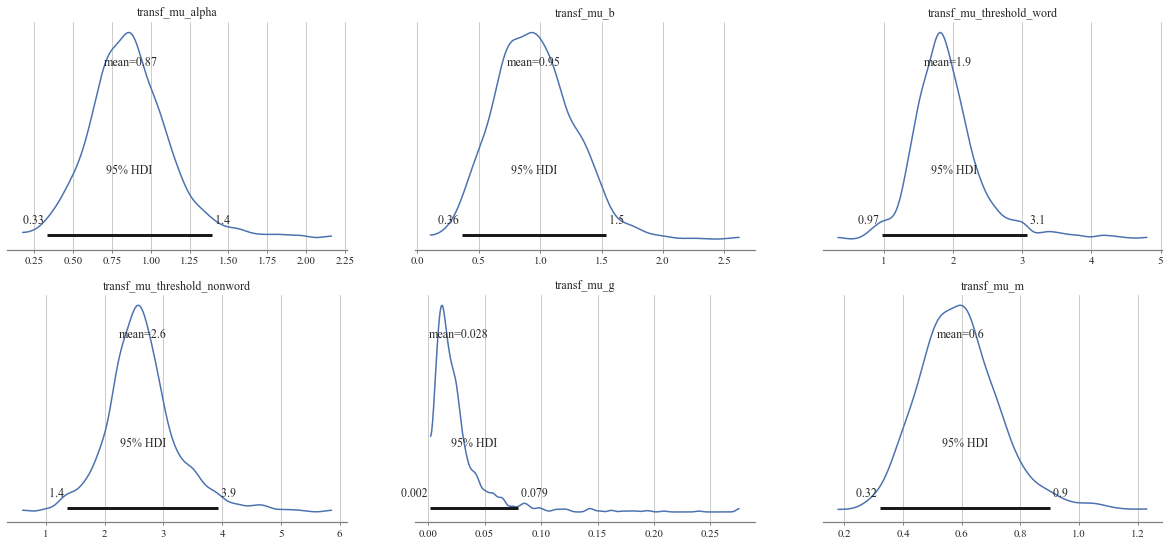

In [57]:
az.plot_posterior(fit, var_names=['transf_mu_alpha', 'transf_mu_b', 'transf_mu_threshold_word', 'transf_mu_threshold_nonword', 'transf_mu_g', 'transf_mu_m'], hdi_prob=.95);
plt.savefig(plots_path + 'Parameters.pdf')

#### Models mean parameters in different conditions

In [25]:
# Loading model parameters for each trial
drift_word_t = fit.stan_variables()['drift_word_t']
drift_nonword_t = fit.stan_variables()['drift_nonword_t']
threshold_t_word = fit.stan_variables()['threshold_t_word']
threshold_t_nonword = fit.stan_variables()['threshold_t_nonword']
ndt_t = fit.stan_variables()['ndt_t']

In [26]:
HF_condition_w = drift_word_t[:, behavioural_df['category']=="HF"]
HF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="HF"]
LF_condition_w = drift_word_t[:, behavioural_df['category']=="LF"]
LF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="LF"]
NW_condition_w = drift_word_t[:, behavioural_df['category']=="NW"]
NW_condition_nw = drift_nonword_t[:, behavioural_df['category']=="NW"]

In [27]:
print('HF words, word drift mean and std:')
print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
print('HF words, nonword drift mean and std:')
print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))

HF words, word drift mean and std:
4.5173214866517855 0.1835213906287642
HF words, nonword drift mean and std:
3.2931139577232145 0.2360445679192576


In [28]:
print('LF words word drift mean and std:')
print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
print('LF words nonword drift mean and std:')
print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))

LF words word drift mean and std:
3.453208618940199 0.18491636774464557
LF words nonword drift mean and std:
3.4849838647840534 0.2221096439673417


In [29]:
print('NW words word drift mean and std:')
print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
print('NW words nonword drift mean and std:')
print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))

NW words word drift mean and std:
1.5044706252738351 0.20516810404900745
NW words nonword drift mean and std:
4.571759806272402 0.19520746895257413


In [30]:
HF_condition_w = threshold_t_word[:, behavioural_df['category']=="HF"]
HF_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="HF"]
LF_condition_w = threshold_t_word[:, behavioural_df['category']=="LF"]
LF_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="LF"]
NW_condition_w = threshold_t_word[:, behavioural_df['category']=="NW"]
NW_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="NW"]

In [31]:
print('HF words, word threshold mean and std:')
print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
print('HF words, nonword threshold mean and std:')
print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))

HF words, word threshold mean and std:
1.7350871515178568 0.12280499145644092
HF words, nonword threshold mean and std:
2.4790083177678577 0.148028444466073


In [32]:
print('LF words word threshold mean and std:')
print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
print('LF words nonword threshold mean and std:')
print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))

LF words word threshold mean and std:
1.7306533229568108 0.1221674029710403
LF words nonword threshold mean and std:
2.4722744736544855 0.14715574627690672


In [33]:
print('NW words word threshold mean and std:')
print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
print('NW words nonword threshold mean and std:')
print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))

NW words word threshold mean and std:
1.740265069103943 0.12168945696617389
NW words nonword threshold mean and std:
2.486529254982078 0.14657155955802637


In [34]:
HF_condition = ndt_t[:, behavioural_df['category']=="HF"]
LF_condition = ndt_t[:, behavioural_df['category']=="LF"]
NW_condition = ndt_t[:, behavioural_df['category']=="NW"]

In [35]:
print('HF words ndt_t mean and std:')
print(np.mean(np.mean(HF_condition, axis=1)), np.std(np.mean(HF_condition, axis=1)))

HF words ndt_t mean and std:
0.177140484353125 0.015975942393366502


In [36]:
print('LF words ndt_t mean and std:')
print(np.mean(np.mean(LF_condition, axis=1)), np.std(np.mean(LF_condition, axis=1)))

LF words ndt_t mean and std:
0.18306890766315612 0.016024584290571978


In [37]:
print('Non Words ndt_t mean and std:')
print(np.mean(np.mean(NW_condition, axis=1)), np.std(np.mean(NW_condition, axis=1)))

Non Words ndt_t mean and std:
0.18036376688521502 0.015978408484134243


## Calculating metrics

In [38]:
def calculate_waic(log_likelihood, pointwise=False):
    """
    Returns model comparisions' metrics.
    
    Parameters
    ----------
        log_likelihood: np.array
            log_likelihood of each trial
        max_rt: float
            maximum acceptable rt
        min_rt: float
             minimum acceptable rt
             
    Optional Parameters
    ----------------
    pointwise: float
        if true pointwise waic will be calculated
        
    Returns
    -------
        out:  a dictionary containing lppd, waic, waic_se and pointwise_waic    
    """
    likelihood = np.exp(log_likelihood)

    mean_l = np.mean(likelihood, axis=0) # N observations

    pointwise_lppd = np.log(mean_l)
    lppd = np.sum(pointwise_lppd)

    pointwise_var_l = np.var(log_likelihood, axis=0) # N observations
    var_l = np.sum(pointwise_var_l)

    pointwise_waic = - 2*pointwise_lppd +  2*pointwise_var_l
    waic = -2*lppd + 2*var_l
    waic_se = np.sqrt(log_likelihood.shape[1] * np.var(pointwise_waic))

    if pointwise:
        out = {'lppd':lppd,
               'p_waic':var_l,
               'waic':waic,
               'waic_se':waic_se,
               'pointwise_waic':pointwise_waic}
    else:
        out = {'lppd':lppd,
               'p_waic':var_l,
                'waic':waic,
                'waic_se':waic_se}
    return out

In [40]:
log_likelihood = fit.stan_variables()['log_lik']
calculate_waic(log_likelihood)

{'lppd': 181.36910828239422,
 'p_waic': 23.196760860812162,
 'waic': -316.3446948431641,
 'waic_se': 77.05393336564921}

## Simulating RDM with estimated parameters

In [41]:
def random_rdm_2A(cor_drift, inc_drift, threshold_word, threshold_nonword, ndt, noise_constant=1, dt=0.001, max_rt=10):
    """ 
    Simulates behavior (rt and accuracy) according to the Racing Diffusion Model.
     
    Parameters
    ----------
    cor_drift : numpy.ndarray
        Drift-rate of the Racing Diffusion Model - correct trials.
    inc_drift : numpy.ndarray
        Drift-rate of the Racing Diffusion Model - incorrect trials.
    threshold : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Threshold of the diffusion decision model.
    ndt : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Non decision time of the diffusion decision model, in seconds.
    
    Optional Parameters
    ----------------
    noise_constant : float, default 1
        Scaling factor of the Racing Diffusion Model.
        If changed, drift and threshold would be scaled accordingly.
        Not to be changed in most applications.
    dt : float, default 0.001
        Controls the time resolution of the Racing Diffusion Model. Default is 1 msec.
        Lower values of dt make the function more precise but much slower.
    max_rt : float, default 10
        Controls the maximum rts that can be predicted.
        Making this higher might make the function a bit slower.
    
    Returns
    -------
    rt : numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated response times according to the Racing Diffusion Model.
        Every element corresponds to the set of parameters given as input with the same shape.
    acc: numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated accuracy according to the Racing Diffusion Model.
        Every element corresponds to the set of parameters given as input with the same shape.
    """
    shape = cor_drift.shape
    acc = np.empty(shape)
    rt = np.empty(shape)
    acc[:] = np.nan
    rt[:] = np.nan

    max_tsteps = max_rt/dt

    x_cor = np.zeros(shape)
    x_inc = np.zeros(shape)

    tstep = 0
    ongoing = np.array(np.ones(shape), dtype=bool)

    stop_race = False

    while np.sum(ongoing) > 0 and tstep < max_tsteps:
        x_cor[ongoing] += np.random.normal(cor_drift[ongoing]*dt,
                                           noise_constant*np.sqrt(dt),
                                           np.sum(ongoing))
        x_inc[ongoing] += np.random.normal(inc_drift[ongoing]*dt,
                                           noise_constant*np.sqrt(dt),
                                           np.sum(ongoing))
        tstep += 1
        ended_correct = (x_cor >= threshold_word)
        ended_incorrect = (x_inc >= threshold_nonword)

        # store results and filter out ended trials
        if np.sum(ended_correct) > 0:
            acc[np.logical_and(ended_correct, ongoing)] = 1
            rt[np.logical_and(ended_correct, ongoing)] = dt*tstep + ndt[np.logical_and(ended_correct, ongoing)]
            ongoing[ended_correct] = False

        if np.sum(ended_incorrect) > 0:
            acc[np.logical_and(ended_incorrect, ongoing)] = 0
            rt[np.logical_and(ended_incorrect, ongoing)] = dt*tstep + ndt[np.logical_and(ended_incorrect, ongoing)]
            ongoing[ended_incorrect] = False
    return rt, acc

Simulating RDM with estimated parameters

In [42]:
pp_rt, pp_response = random_rdm_2A(drift_word_t, drift_nonword_t, threshold_t_word, threshold_t_nonword, ndt_t, noise_constant=1, dt=0.001, max_rt=5)

In [43]:
def bci(x, alpha=0.05):
    """
    Calculate Bayesian credible interval (BCI).
    
    Parameters
    ----------
    x : array-like
        An array containing MCMC samples.
    
    Optional Parameters
    -------------------
    alpha : float, default 0.05
        Desired probability of type I error.
    
    Returns
    -------
    interval : numpy.ndarray
        Array containing the lower and upper bounds of the bci interval.
    """
    interval = np.nanpercentile(x, [(alpha/2)*100, (1-alpha/2)*100])

    return interval

In [44]:
# Predicted Data
rt_predictions = pd.concat((pd.DataFrame(pp_rt, index=pd.Index(np.arange(1, len(pp_rt)+1))).T, behavioural_df['category']), axis=1)
response_predictions = pd.concat((pd.DataFrame(pp_response, index=pd.Index(np.arange(1, len(pp_response)+1))).T, behavioural_df['category']), axis=1)

# Experiment Data
experiment_data = behavioural_df.loc[:, ['rt', 'response', 'category']]

Separating RT and Response of predicted and experimental data for each condition

In [45]:
HF_data = experiment_data.loc[experiment_data['category']=='HF']
LF_data = experiment_data.loc[experiment_data['category']=='LF']
NW_data = experiment_data.loc[experiment_data['category']=='NW']

HF_pred_rt = rt_predictions.loc[rt_predictions['category']=='HF']
HF_pred_resp = response_predictions.loc[response_predictions['category']=='HF']
LF_pred_rt = rt_predictions.loc[rt_predictions['category']=='LF']
LF_pred_resp = response_predictions.loc[response_predictions['category']=='LF']
NW_pred_rt = rt_predictions.loc[rt_predictions['category']=='NW']
NW_pred_resp = response_predictions.loc[response_predictions['category']=='NW']

## Quantiles Posterior Predictions

In [46]:
quantiles = [.1, .3, .5, .7, .9]
percentiles = np.array(quantiles)*100

In [47]:
# experiment Data quantile
HF_quantile_ex = HF_data['rt'].quantile(quantiles)
LF_quantile_ex = LF_data['rt'].quantile(quantiles)
NW_quantile_ex = NW_data['rt'].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_quantile_pred = HF_pred_rt.quantile(quantiles, axis=0).T
LF_quantile_pred = LF_pred_rt.quantile(quantiles, axis=0).T
NW_quantile_pred = NW_pred_rt.quantile(quantiles, axis=0).T

# predicted data quantiles bci
HF_predicted_bci = np.array([bci(HF_quantile_pred[x]) for x in quantiles])
LF_predicted_bci = np.array([bci(LF_quantile_pred[x]) for x in quantiles])
NW_predicted_bci = np.array([bci(NW_quantile_pred[x]) for x in quantiles])

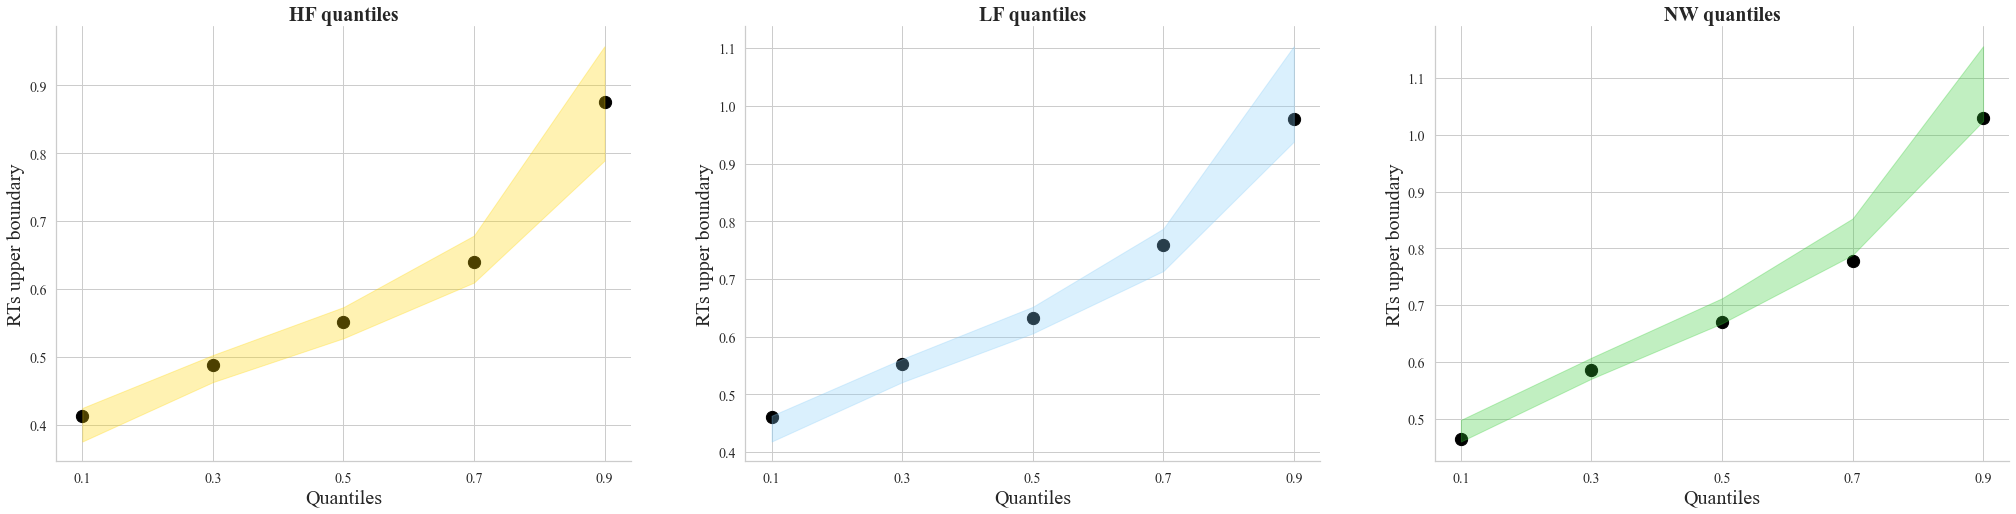

In [48]:
fig, axes = plt.subplots(1,3 , figsize=(35,8))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title('HF quantiles', fontweight="bold", size=20)
axes[1].set_title('LF quantiles', fontweight="bold", size=20)
axes[2].set_title('NW quantiles', fontweight="bold", size=20)

axes[0].scatter(quantiles, HF_quantile_ex, color='black', s=150)
axes[1].scatter(quantiles, LF_quantile_ex, color='black', s=150)
axes[2].scatter(quantiles, NW_quantile_ex, color='black', s=150)

axes[0].fill_between(quantiles,
                HF_predicted_bci[:, 0],
                HF_predicted_bci[:, 1],
                HF_predicted_bci[:, 0] < HF_predicted_bci[:, 1],  color = 'gold', alpha=0.3)

axes[1].fill_between(quantiles,
                LF_predicted_bci[:, 0],
                LF_predicted_bci[:, 1],
                LF_predicted_bci[:, 0] < LF_predicted_bci[:, 1],  color = 'lightskyblue', alpha=0.3)

axes[2].fill_between(quantiles,
                NW_predicted_bci[:, 0],
                NW_predicted_bci[:, 1],
                NW_predicted_bci[:, 0] < NW_predicted_bci[:, 1],  color = 'limegreen', alpha=0.3)


for ax in axes:
        ax.set_xlabel('Quantiles', fontsize=20)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary', fontsize=20)
        for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(14) 

sns.despine()
plt.savefig(plots_path + 'Quantiles Poseterior.pdf')

## Mean Accuracy and RT Posterior Plots

In [49]:
HF_data_rt_mean = HF_data['rt'].mean()
LF_data_rt_mean = LF_data['rt'].mean()
NW_data_rt_mean = NW_data['rt'].mean()

HF_pred_rt_mean = HF_pred_rt.mean(axis=0)
LF_pred_rt_mean = LF_pred_rt.mean(axis=0)
NW_pred_rt_mean = NW_pred_rt.mean(axis=0)


HF_data_resp_mean = HF_data['response'].mean()
LF_data_resp_mean = LF_data['response'].mean()
NW_data_resp_mean = NW_data['response'].mean()

HF_pred_resp_mean = HF_pred_resp.mean(axis=0)
LF_pred_resp_mean = LF_pred_resp.mean(axis=0)
NW_pred_resp_mean = NW_pred_resp.mean(axis=0)


C:\Users\mahva\AppData\Local\Temp\ipykernel_6456\447608752.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  HF_pred_rt_mean = HF_pred_rt.mean(axis=0)
C:\Users\mahva\AppData\Local\Temp\ipykernel_6456\447608752.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  LF_pred_rt_mean = LF_pred_rt.mean(axis=0)
C:\Users\mahva\AppData\Local\Temp\ipykernel_6456\447608752.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  NW_pred_rt_mean = NW_pred_rt.mean(axis=0)
C:\Users\mahva\AppData\Local\Te

In [50]:
def plot_posterior(x, data_mean, ax):
    """
    Plots the posterior of x with experimental data mean as a line
    
    Parameters
    ----------
    x : array-like
        An array containing RT or response for each trial.
        
    x : float
        mean of RT or Accuracy of experimental data.

    ax : matplotlib.axes.Axes
        
    Returns
    -------
    None
    """
    density = gaussian_kde(x, bw_method='scott')
    xd = np.linspace(x.min(), x.max())
    yd = density(xd)

    low, high = bci(x)
    ax.fill_between(xd[np.logical_and(xd >= low, xd <= high)],
                     yd[np.logical_and(xd >= low, xd <= high)], color='lightsteelblue')

    ax.plot(xd, yd, color='slategray')
    ax.axvline(data_mean, color='red')

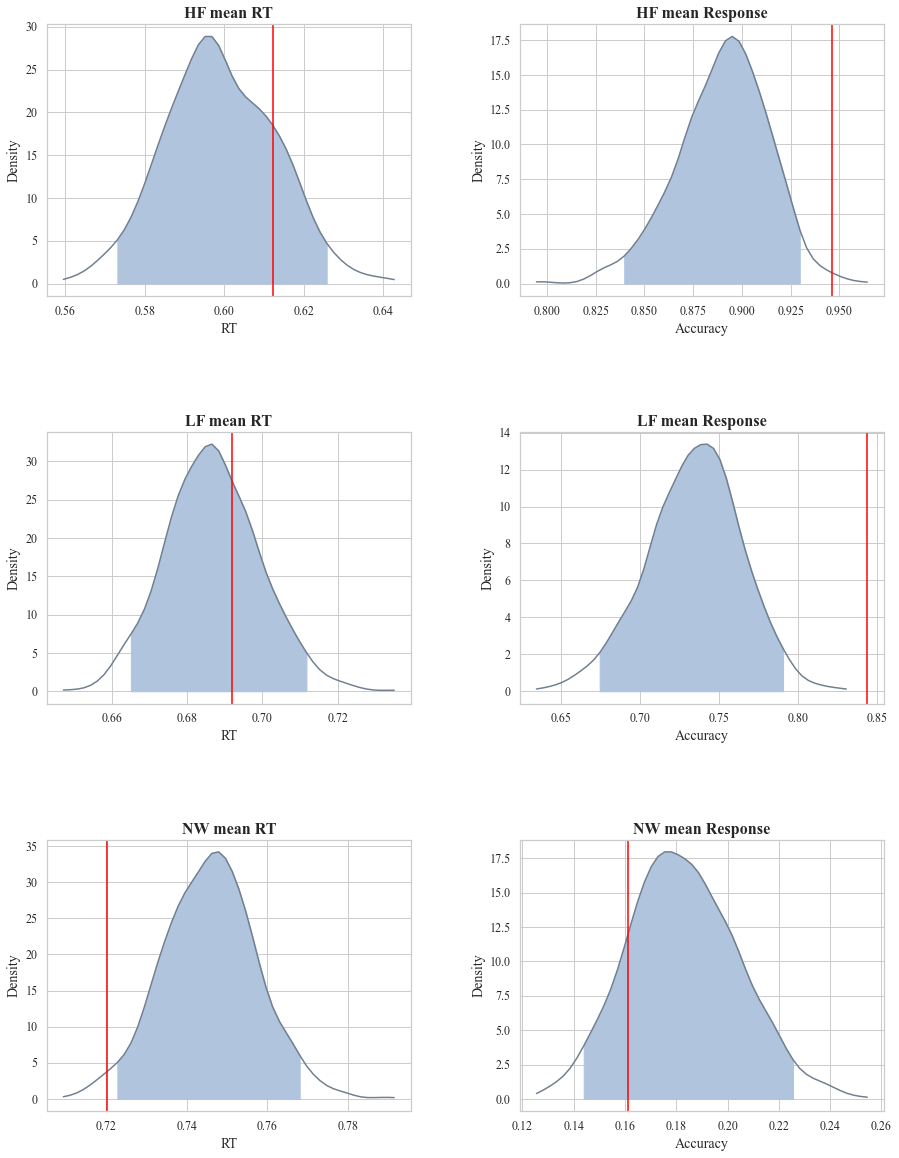

In [51]:
fig, axes = plt.subplots(3,2 , figsize=(15,20))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title('HF mean RT', fontweight="bold", size=16)
axes[0][1].set_title('HF mean Response', fontweight="bold", size=16)
axes[1][0].set_title('LF mean RT', fontweight="bold", size=16)
axes[1][1].set_title('LF mean Response', fontweight="bold", size=16)
axes[2][0].set_title('NW mean RT', fontweight="bold", size=16)
axes[2][1].set_title('NW mean Response', fontweight="bold", size=16)

plot_posterior(HF_pred_rt_mean, HF_data_rt_mean, axes[0][0])
plot_posterior(HF_pred_resp_mean, HF_data_resp_mean, axes[0][1])

plot_posterior(LF_pred_rt_mean, LF_data_rt_mean, axes[1][0])
plot_posterior(LF_pred_resp_mean, LF_data_resp_mean, axes[1][1])

plot_posterior(NW_pred_rt_mean, NW_data_rt_mean, axes[2][0])
plot_posterior(NW_pred_resp_mean, NW_data_resp_mean, axes[2][1])

for ax in axes:
        ax[0].set_xlabel('RT', fontsize=14)
        ax[1].set_xlabel('Accuracy', fontsize=14)
        ax[0].set_ylabel('Density', fontsize=14)
        ax[1].set_ylabel('Density', fontsize=14)
        for tick in ax[0].xaxis.get_major_ticks():
                tick.label.set_fontsize(12)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label.set_fontsize(12)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label.set_fontsize(12)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label.set_fontsize(12) 

plt.savefig(plots_path + 'Mean Accuracy and RT.pdf')